In [1]:
from opt_einsum import contract
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

device=torch.device('cuda:0')
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
torch.cuda.set_device(device)

In [2]:
from HOTRGZ2 import forward_observable_tensors
from TNModels import Ising2D
from ScalingDimensions import show_diff,show_scaling_dimensions


In [54]:
options,params,layers,Ts,logTotals=torch.load('data/hotrg_gilt_X24.pkl',map_location=device)
layers=layers[:30]
Ts=Ts[:31]

  0%|          | 0/31 [00:00<?, ?it/s]

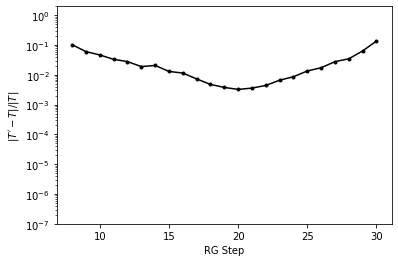

  0%|          | 0/31 [00:00<?, ?it/s]

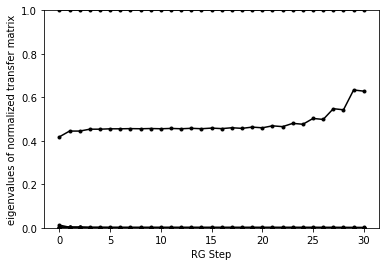

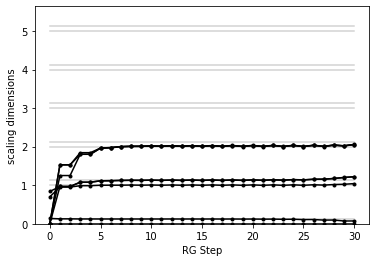

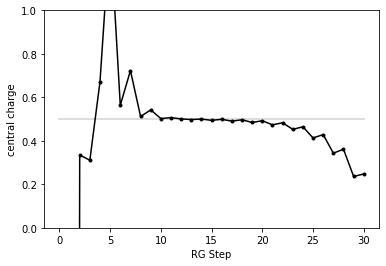

In [55]:

model=Ising2D(params)
T0=model.get_T0()
T0_op=model.get_SZT0()
checkboard=False

data_diff=show_diff(Ts,stride=2)
data_scDim=show_scaling_dimensions(Ts,is_HOTRG=2,reference_center_charge=.5,reference_scaling_dimensions=[0,0.125,1,1.125,2,2.125,3,3.125,4,4.125,5,5.125])

In [56]:

def get_isometry_from_matrix(M):
    u,s,vh=torch.svd(M)
    return u@vh


def calc_gilt_loss(T0,layer):
    assert len(T0.shape)==4
    gg=layer.gg
    gT0=contract('ijkl,Ii,Jj,Kk,Ll->IJKL',T0,*gg[0])
    ii=[get_isometry_from_matrix(g) for g in gg[0]]
    iT0=contract('ijkl,Ii,Jj,Kk,Ll->IJKL',T0,*ii)
    #iT0=T0
    iidot=contract('ijkl,ijkl->',iT0,iT0.conj())
    ggdot=contract('ijkl,ijkl->',gT0,gT0.conj())
    igdot=contract('ijkl,ijkl->',iT0,gT0.conj())
    return 1-ggdot/iidot,1-igdot/torch.sqrt(iidot*ggdot)

from HOTRGZ2 import RepMat
def calc_hotrg_loss(Ta,Tb,layer):
    assert len(Ta.shape)==4
    ww,dimR,gg,hh,T0Shape=layer.ww,layer.dimR,layer.gg,layer.hh,layer.tensor_shape
    assert T0Shape==Ta.shape and T0Shape==Tb.shape
    if gg:
        gTa=contract('ijkl,Ii,Jj,Kk,Ll->IJKL',Ta,*gg[0])
        gTb=contract('ijkl,Ii,Jj,Kk,Ll->IJKL',Tb,*gg[1])
    if dimR:
        P=RepMat(dimR[1][0],dimR[1][1],dimR[1][0],dimR[1][1])
        wP=contract('ab,bij->aij',ww[0],P)
    else:
        wP=ww[0].reshape(-1,gTa.shape[2],gTb.shape[2])
    wgT=contract('ijkl,jmno,akn,blo->imab',gTa,gTb,wP,wP.conj())
    wwdot=contract('ijkl,ijkl->',wgT,wgT.conj())
    ggdot=contract('ijkl,jmno,iJkl,Jmno->',gTa,gTb,gTa.conj(),gTb.conj())
    TTdot=contract('ijkl,jmno,iJkl,Jmno->',Ta,Tb,Ta.conj(),Tb.conj())
    return 1-wwdot/TTdot,1-wwdot/ggdot


In [62]:
data=[]

In [63]:
for iLayer in tqdm(range(len(layers))):
    T1,T1_op,_=forward_observable_tensors(T0,[T0],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    gilt_loss_norm,gilt_loss_dot=calc_gilt_loss(T1_op,layers[iLayer])
    hotrg_gilt_loss_norm,hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'id',
                    'gilt_loss_norm':gilt_loss_norm.item(),
                    'gilt_loss_dot':gilt_loss_dot.item(),
                    'hotrg_gilt_loss_norm':hotrg_gilt_loss_norm.item(),
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/30 [00:00<?, ?it/s]

In [64]:
for iLayer in tqdm(range(len(layers))):
    T1,T1_op,_=forward_observable_tensors(T0,[T0_op],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    gilt_loss_norm,gilt_loss_dot=calc_gilt_loss(T1_op,layers[iLayer])
    hotrg_gilt_loss_norm,hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'σ',
                    'gilt_loss_norm':gilt_loss_norm.item(),
                    'gilt_loss_dot':gilt_loss_dot.item(),
                    'hotrg_gilt_loss_norm':hotrg_gilt_loss_norm.item(),
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/30 [00:00<?, ?it/s]

In [65]:
for iLayer in tqdm(range(1,len(layers))):
    T1,T1_op,_=forward_observable_tensors(T0,[T0_op,T0_op],[(0,0),(1,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    T1_op=T1_op-contract('ijkl,ijkl->',T1_op,T1)/contract('ijkl,ijkl->',T1,T1)*T1
    gilt_loss_norm,gilt_loss_dot=calc_gilt_loss(T1_op,layers[iLayer])
    hotrg_gilt_loss_norm,hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'σσ-id',
                    'gilt_loss_norm':gilt_loss_norm.item(),
                    'gilt_loss_dot':gilt_loss_dot.item(),
                    'hotrg_gilt_loss_norm':hotrg_gilt_loss_norm.item(),
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/29 [00:00<?, ?it/s]

In [66]:
for iLayer in tqdm(range(1,len(layers))):
    T1,T1_op1,_=forward_observable_tensors(T0,[T0_op],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op2,_=forward_observable_tensors(T0,[T0_op],[(1,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    T1_op=T1_op1-T1_op2
    gilt_loss_norm,gilt_loss_dot=calc_gilt_loss(T1_op,layers[iLayer])
    hotrg_gilt_loss_norm,hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'∂σ',
                    'gilt_loss_norm':gilt_loss_norm.item(),
                    'gilt_loss_dot':gilt_loss_dot.item(),
                    'hotrg_gilt_loss_norm':hotrg_gilt_loss_norm.item(),
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/29 [00:00<?, ?it/s]

In [67]:
for iLayer in tqdm(range(2,len(layers))):
    T1,T1_op1,_=forward_observable_tensors(T0,[T0_op,T0_op],[(0,0),(1,1)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op2,_=forward_observable_tensors(T0,[T0_op,T0_op],[(1,0),(0,1)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)

    T1_op=T1_op1-T1_op2
    gilt_loss_norm,gilt_loss_dot=calc_gilt_loss(T1_op,layers[iLayer])
    hotrg_gilt_loss_norm,hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'T',
                    'gilt_loss_norm':gilt_loss_norm.item(),
                    'gilt_loss_dot':gilt_loss_dot.item(),
                    'hotrg_gilt_loss_norm':hotrg_gilt_loss_norm.item(),
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/28 [00:00<?, ?it/s]

In [68]:
for iLayer in tqdm(range(3,len(layers))):
    T1,T1_op1,_=forward_observable_tensors(T0,[T0_op],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op2,_=forward_observable_tensors(T0,[T0_op],[(1,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op3,_=forward_observable_tensors(T0,[T0_op],[(2,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    T1_op=T1_op1-2*T1_op2+T1_op3
    gilt_loss_norm,gilt_loss_dot=calc_gilt_loss(T1_op,layers[iLayer])
    hotrg_gilt_loss_norm,hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'∂∂σ',
                    'gilt_loss_norm':gilt_loss_norm.item(),
                    'gilt_loss_dot':gilt_loss_dot.item(),
                    'hotrg_gilt_loss_norm':hotrg_gilt_loss_norm.item(),
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/27 [00:00<?, ?it/s]

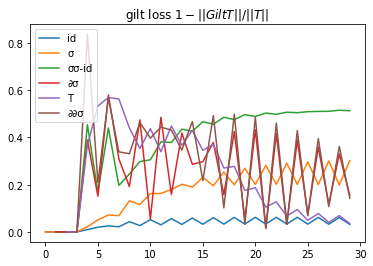

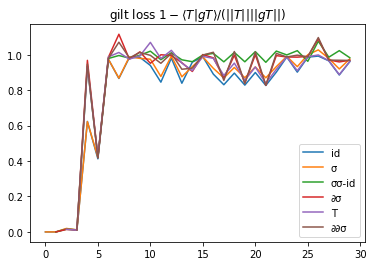

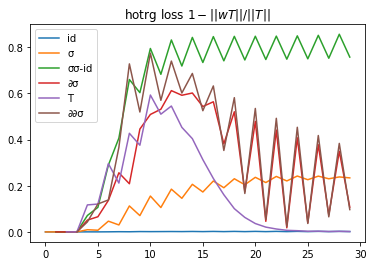

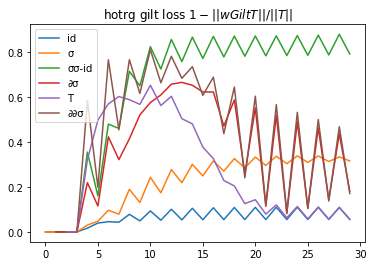

In [71]:
curve=pd.DataFrame(data)

from matplotlib import pyplot as plt

for operator in curve['operator'].unique():
    curve1=curve[curve['operator']==operator]
    plt.plot(curve1['layer'],curve1['gilt_loss_norm'],label=operator)

plt.title(r'gilt loss $1-|| g T || / ||T||$')
plt.legend()
plt.show()

for operator in curve['operator'].unique():
    curve1=curve[curve['operator']==operator]
    plt.plot(curve1['layer'],curve1['gilt_loss_dot'],label=operator)

plt.title(r'gilt loss $1-\langle T | g T \rangle/(||T||||g T||)$')
plt.legend()
plt.show()

for operator in curve['operator'].unique():
    curve1=curve[curve['operator']==operator]
    plt.plot(curve1['layer'],curve1['hotrg_loss_norm'],label=operator)

plt.title(r'hotrg loss $1-|| w T || / ||T||$')
plt.legend()
plt.show()

for operator in curve['operator'].unique():
    curve1=curve[curve['operator']==operator]
    plt.plot(curve1['layer'],curve1['hotrg_gilt_loss_norm'],label=operator)

plt.title(r'hotrg gilt loss $1-|| w g T || / ||T||$')
plt.legend()
plt.show()

In [42]:
options,params,layers,Ts,logTotals=torch.load('data/hotrg_X24.pkl',map_location=device)
layers=layers[:30]
Ts=Ts[:31]



In [44]:
data=[]
for iLayer in tqdm(range(len(layers))):
    T1,T1_op,_=forward_observable_tensors(T0,[T0],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'id',
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })
for iLayer in tqdm(range(len(layers))):
    T1,T1_op,_=forward_observable_tensors(T0,[T0_op],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'σ',
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })
for iLayer in tqdm(range(1,len(layers))):
    T1,T1_op,_=forward_observable_tensors(T0,[T0_op,T0_op],[(0,0),(1,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    T1_op=T1_op-contract('ijkl,ijkl->',T1_op,T1)/contract('ijkl,ijkl->',T1,T1)*T1
    hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'σσ-id',
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })
for iLayer in tqdm(range(1,len(layers))):
    T1,T1_op1,_=forward_observable_tensors(T0,[T0_op],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op2,_=forward_observable_tensors(T0,[T0_op],[(1,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    T1_op=T1_op1-T1_op2
    hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'∂σ',
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })
for iLayer in tqdm(range(2,len(layers))):
    T1,T1_op1,_=forward_observable_tensors(T0,[T0_op,T0_op],[(0,0),(1,1)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op2,_=forward_observable_tensors(T0,[T0_op,T0_op],[(1,0),(0,1)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)

    T1_op=T1_op1-T1_op2
    hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'T',
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })
for iLayer in tqdm(range(3,len(layers))):
    T1,T1_op1,_=forward_observable_tensors(T0,[T0_op],[(0,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op2,_=forward_observable_tensors(T0,[T0_op],[(1,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    _,T1_op3,_=forward_observable_tensors(T0,[T0_op],[(2,0)],layers[:iLayer],checkboard,cached_Ts=Ts,user_tqdm=False)
    T1_op=T1_op1-2*T1_op2+T1_op3
    hotrg_loss_norm=calc_hotrg_loss(T1,T1_op,layers[iLayer])
    data.append({'layer':iLayer,'operator':'∂∂σ',
                    'hotrg_loss_norm':hotrg_loss_norm.item(),
                  })

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

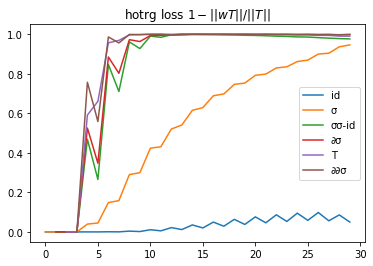

In [45]:
curve=pd.DataFrame(data)

from matplotlib import pyplot as plt


for operator in curve['operator'].unique():
    curve1=curve[curve['operator']==operator]
    plt.plot(curve1['layer'],curve1['hotrg_loss_norm'],label=operator)

plt.title(r'hotrg loss $1-|| w T || / ||T||$')
plt.legend()
plt.show()